In [1]:
!pip install kaggle

In [2]:
from google.colab import files

In [3]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d oarcanjomiguel/citrus-greening
!unzip -q citrus-greening.zip -d dataset

100% 1.38G/1.38G [00:14<00:00, 105MB/s] 
100% 1.38G/1.38G [00:14<00:00, 103MB/s]


In [6]:
import os
import cv2
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

In [7]:
greening_path = '/content/dataset/field/greening'
healthy_path = '/content/dataset/field/healthy'

In [8]:
def load_images(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (64, 64))  # Resize the image to a fixed size
        images.append(img)
        labels.append(label)
    return images, labels

In [9]:
greening_images, greening_labels = load_images(greening_path, label=0)
healthy_images, healthy_labels = load_images(healthy_path, label=1)

In [10]:
# Combining the datasets
all_images = greening_images + healthy_images
all_labels = greening_labels + healthy_labels

In [11]:
# Converting to NumPy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

In [12]:
print(len(all_images))
print(len(all_labels))

377
377


In [13]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

301
76
301
76


In [14]:
# Normalizing pixel values to be between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0

In [15]:
# Defining a CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='linear'))  # 2 output neurons for the two actions (greening or healthy)

In [16]:
model.compile(optimizer='adam', loss='mse')  # Mean Squared Error loss for Q-learning

In [17]:
# Defining the reinforcement learning environment
class PlantEnvironment:
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.current_index = 0
        self.done = False

    def reset(self):
        self.current_index = 0
        self.done = False
        return self.get_state()

    def get_state(self):
        return self.images[self.current_index], self.labels[self.current_index]

    def step(self, action):
        self.current_index += 1
        if self.current_index == (len(self.images) - 1):
            self.done = True
        next_state = self.get_state()
        reward = 1 if action == next_state[1] else -1  # Reward for correct action, penalty for incorrect action
        return next_state, reward, self.done

In [18]:
# Creating the reinforcement learning environment
env = PlantEnvironment(images=X_train, labels=y_train)

In [19]:
# Define the Q-learning agent
class PlantAgent:
    def __init__(self, model, action_space, learning_rate=0.001, discount_factor=0.9, epsilon=0.1):
        self.model = model
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return random.choice(self.action_space)  # Exploratory action
        else:
            q_values = self.model.predict(np.expand_dims(state[0], axis=0))[0]
            return np.argmax(q_values)  # Exploitative action

    def update_q_values(self, state, action, reward, next_state):
        current_q_values = self.model.predict(np.expand_dims(state[0], axis=0))[0]
        next_q_values = self.model.predict(np.expand_dims(next_state[0], axis=0))[0]
        td_target = reward + self.discount_factor * np.max(next_q_values)
        td_error = td_target - current_q_values[action]
        current_q_values[action] += self.learning_rate * td_error
        return current_q_values

In [20]:
# Creating the Q-learning agent
agent = PlantAgent(model=model, action_space=[0, 1])

In [21]:
# Training
num_episodes = 50

# Initialize lists to store rewards during training
training_rewards = []

for episode in range(num_episodes):
    state = env.reset()
    done = False
    episode_reward = 0

    while not done:
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)
        q_values = agent.update_q_values(state, action, reward, next_state)
        state = next_state
        episode_reward += reward

    # Store the reward for this episode
    training_rewards.append(episode_reward)

print("Training complete.")

Se han truncado las últimas 5000 líneas del flujo de salida.
1/1 [==============================] - 0s 44ms/step
Training complete.


In [22]:
print(f"Training rewards: {len(training_rewards)}", training_rewards)

Training rewards: 50 [8, -2, 20, 20, 18, 24, 10, 20, 12, 6, 10, 8, 10, 8, 24, 0, 14, 14, 20, 22, 22, 14, 12, 14, 18, 22, 10, 14, 10, 0, 24, 8, -2, 14, 18, 14, 16, 14, 4, 24, 0, 26, 12, 2, 10, 26, 0, 10, 12, 0]


In [23]:
# Evaluation
test_env = PlantEnvironment(images=X_test, labels=y_test)

In [24]:
# Initialize a list to store rewards during evaluation
evaluation_rewards = []

In [25]:
state = test_env.reset()
done = False
total_reward = 0

while not done:
    action = agent.choose_action(state)
    next_state, reward, done = test_env.step(action)
    total_reward += reward

# Store the total reward for evaluation
evaluation_rewards.append(total_reward)

print(f"Total reward on the test set: {total_reward}", evaluation_rewards)

1/1 [==============================] - 0s 25ms/step
Total reward on the test set: -15 [-15]


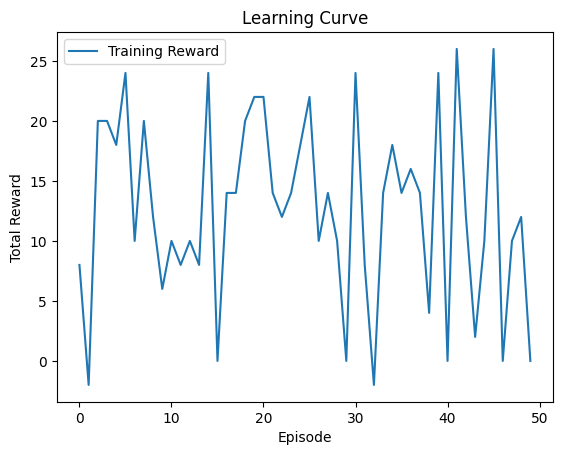

In [26]:
# Visualizations and Analysis
import matplotlib.pyplot as plt

# Plot the learning curve
plt.plot(training_rewards, label='Training Reward')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Learning Curve')
plt.legend()
plt.show()
